In [1]:
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from datetime import datetime

from shapely.geometry import Point

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import weibull_min
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from playsound import playsound

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update, compute_beta, str_exp_fun, epl_fun, myfun_sse, down_wei, down_wei_beta_alpha
from ART_preprocessing import haversine, create_box, space_time_scales_agregations, wet_matrix_extrapolation, autocorrelation_neighborhood, area_lat_lon, spatial_correlation
from ART_plot import plot_neighborhood, plot_scales_aggregation, plot_wet_fraction_matrix, plot_autocorrelation, plot_scatter

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## Downscaling to the manual IMERG pixel

In [2]:
yy_s, yy_e = 2001, 2017

In [3]:
CONDITION = 'OVERLEAP'; fig_val = 'OVERLAP'
maxmiss = 50

In [4]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    # DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

DATA

<xarray.Dataset> Size: 646MB
Dimensions:  (time: 67200, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 538kB 2001-01-01 ... 2023-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 645MB ...
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [7]:
lat_c, lon_c = 46.649998, 11.849999

In [8]:
PARAM = dict({
    'L0':0,
    'L1':10,
    
    'maxmiss':40,

    'npix':5,
    'thresh': 2,
    'tmax': 48,
    'dt': 3,
    
    'origin_x': 10,
    'origin_t': 24,
    'target_x': 0,
    'target_t': 24,

    'ninterp':2000,

    'acf': 'mar',
    'corr_method':'pearson',
    'cores': 12,
})

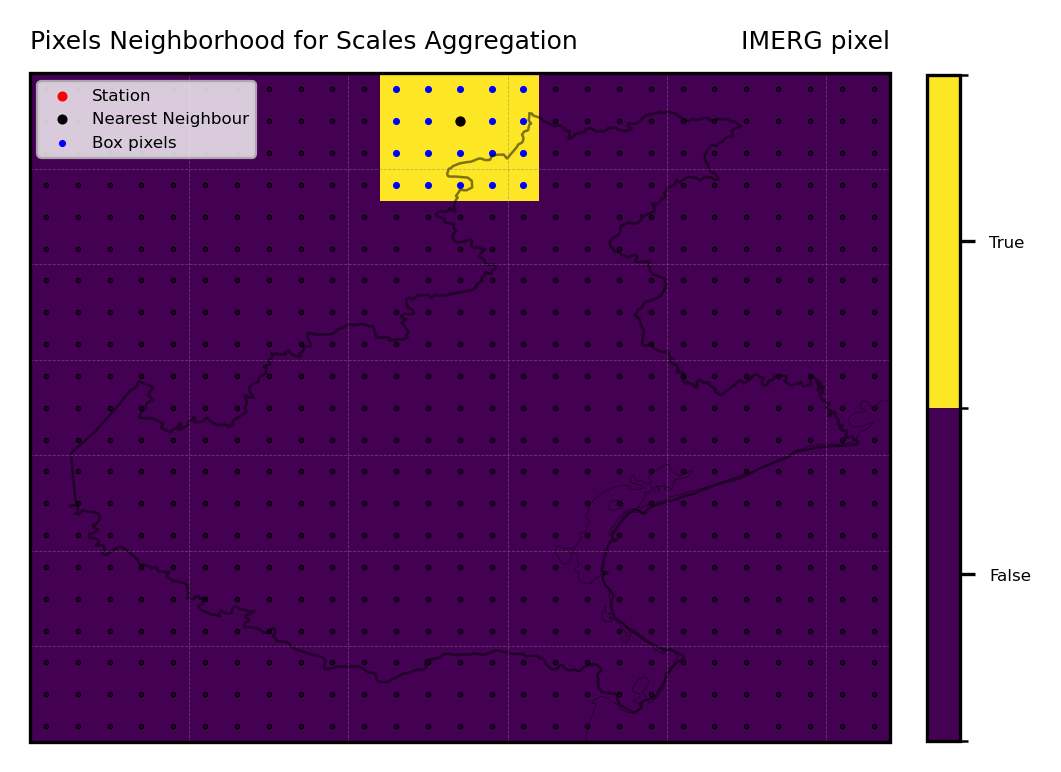

In [11]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)

DATES_daily = PRE_daily['time']

i_ = np.where(lats==lat_c)[0][0]
j_ = np.where(lons==lon_c)[0][0]

IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data

IMERG_pixel_1dy_xr = xr.DataArray(
            IMERG_pixel_1dy, 
            coords={'time':PRE_daily['time'].values}, 
            dims=('time'))

IMERG_WEIBULL_YEAR = fit_yearly_weibull_update(
            IMERG_pixel_1dy_xr, 
            thresh=PARAM['thresh'], 
            maxmiss=PARAM['maxmiss'])

box_3h, bcond = create_box(DATA, lat_c, lon_c, PARAM['npix'], reso=0.1)

Station_pos = lat_c, lon_c
close_pixel = lat_c, lon_c

plot_neighborhood(box_3h, lon2d, lat2d, bcond, Station_pos, close_pixel, 'IMERG pixel', 'None', save=False)

In [12]:
smax = box_3h.shape[0] # max spatial scale
tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*PARAM['dt']
tscales = tscales[tscales < PARAM['tmax'] + 0.001]
xscales = np.arange(1, smax+1)
xscales_km = xscales*PARAM['L1']
ntscales = np.size(tscales)
nsscales = np.size(xscales)

WET_MATRIX = space_time_scales_agregations(
            box_3h, 
            PARAM['L1'], 
            CONDITION, 
            tscales, 
            xscales, 
            PARAM['npix'], 
            PARAM['thresh'])

xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)
ntscales = np.size(tscales)
nxscales = np.size(xscales)

tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), PARAM['ninterp'])
WET_MATRIX_INTER = np.zeros((PARAM['ninterp'], nxscales))

for col in range(nxscales):
    WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

WET_MATRIX_EXTRA, new_spatial_scale = wet_matrix_extrapolation(
            WET_MATRIX_INTER, 
            xscales_km, 
            tscales_INTER, 
            PARAM['L1'], 
            PARAM['npix'])

origin_ref = [PARAM['origin_x'], PARAM['origin_t']]
target_ref = [PARAM['target_x'], PARAM['target_t']]

In [ ]:
origin_ref = [PARAM['origin_x'], PARAM['origin_t']]
target_ref = [PARAM['target_x'], PARAM['target_t']]

beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

In [ ]:
vdist, vcorr, distance_vector = autocorrelation_neighborhood(
            box_3h, 
            t_target = PARAM['target_t'], 
            thresh = PARAM['thresh'], 
            cor_method = PARAM['corr_method'])

FIT, _ = curve_fit(str_exp_fun, vdist, vcorr)
FIT_d0, FIT_mu0 = FIT
FIT, _ = curve_fit(epl_fun, vdist, vcorr)
FIT_eps, FIT_alp = FIT

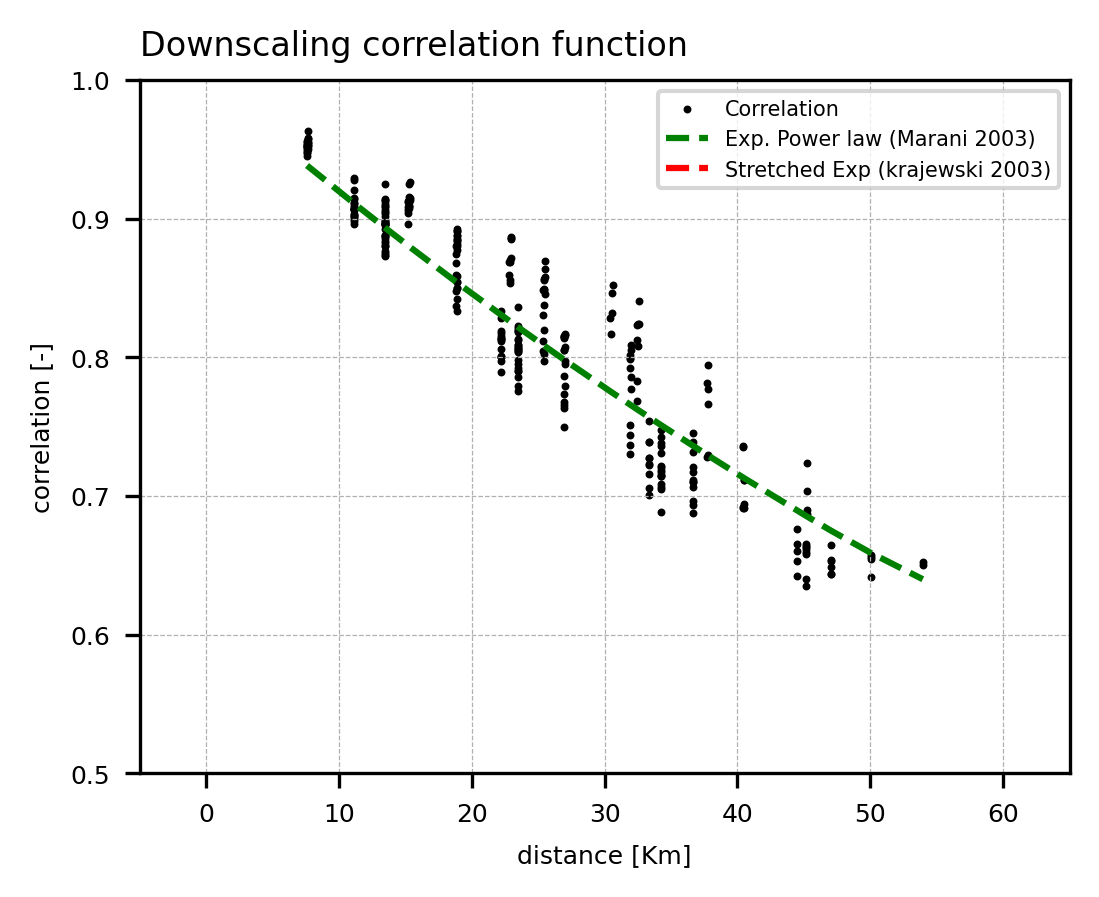

In [21]:
plot_autocorrelation(vdist, vcorr, FIT_eps, FIT_alp, 0, 0, 'None', save=False)